In [1]:
import pandas as pd
import numpy as np
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
import matplotlib.pyplot as plt
import C14preproc as prep
import C14utils
from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset
from scipy.interpolate import interp1d
import isamcalc_lib as isam
import os.path
import uq_lib as uq
import SOCtools as soc
from os import path
from IPython.display import display


In [2]:
#================================================================================
# Initilize the site information
#================================================================================
# obs
obs_fname = 'Non_peat_data_permafrost.csv'
data = pd.read_csv(obs_fname,encoding='iso-8859-1',index_col='ProfileID', skiprows=[1])
all_profid = data.index.unique()
lons = prep.getvarxls(data,'Lon',all_profid[0:16],0)
lats = prep.getvarxls(data,'Lat',all_profid[0:16],0)

# Calibration
isam_cal_d14c_fname = 'isam_dc14_cali.dat'
isam_cal_soc_fname = 'isam_soc_cali.dat'

# Um's results
isam_um_d14c_fname = 'isam_um_dc14.dat'
isam_um_soc_fname = 'isam_um_soc.dat'


In [3]:
# Create dictionaries
site = {
    "43"  : 0,
    "110" : 1,
    "143" : 2,
    "197" : 3,
    "146" : 4,   
}

yr_dict = {
    "43"  : 2001,
    "110" : 2005,
    "143" : 2007,
    "197" : 1999,
    "146" : 2002,   
}

sen_exp = {
    "aa_u"      : 0,    # high 
    "aa_l"      : 1,    # low
    "bb_u"      : 2,
    "bb_l"      : 3,
    "bd_u"      : 4,
    "bd_l"      : 5,
    "d_u"       : 7,
    "d_l"       : 8,
    "dep_u"     : 9,
    "dep_l"     : 10,
    "control"   : 11,
    "q_u"       : 12,
    "q_l"       : 13,
    "s_u"       : 14,
    "s_l"       : 15,
    "gamma_u"   : 16,
    "gamma_l"   : 17,
}

In [4]:
# Read in observations if available
data.nodedepth = data.Layer_top + (data.Layer_bottom - data.Layer_top)/2.

obs_topsoil = np.zeros((3, 5))
obs_subsoil = np.zeros((3, 5))

for siteid, ind in site.items():
    # Node depth
    dn = data.nodedepth.loc[int(float(siteid))].as_matrix()
    # Layer thickness
    dp = (data.Layer_bottom.loc[int(float(siteid))] - data.Layer_top.loc[int(float(siteid))]).as_matrix()
    # Layer interface
    zsoih = np.concatenate((data.Layer_top.loc[int(float(siteid))].as_matrix()[0:1], data.Layer_bottom.loc[int(float(siteid))].as_matrix()))
    # Convert from cm to m
    zsoih = zsoih/100.
    dp = dp/100.
    # Number of layers of the current profile 
    num_obs = data.C_Density[int(float(siteid))].__len__()
    # SOC
    socobs = data.C_Density.loc[int(float(siteid))].as_matrix() * 1000.
    obs_topsoil[0, ind] = soc.aggre_prof_den_to_stock(0.3, zsoih, dp, socobs)
    obs_subsoil[0, ind] = soc.aggre_prof_den_to_stock(1, zsoih, dp, socobs)
    
    # D14C
    d14cobs = data.D14C_BulkLayer.loc[int(float(siteid))].as_matrix()
    # Calculate SOC content profile (kgC m-2) instead of SOC density profile (kgC m-3)
    soc2obs = socobs*dp
    obs_topsoil[1, ind] = C14utils.avg_soc_weighted_d14c(0.3, zsoih, dp, soc2obs, d14cobs)
    obs_subsoil[1, ind] = C14utils.avg_soc_weighted_d14c(1.0, zsoih, dp, soc2obs, d14cobs)
    
# Calculate the turnover time
sampleyr = [2001, 2005, 2007, 1999, 2002]
tau, cost = C14utils.cal_tau(obs_topsoil[1,:], sampleyr, 1, 0)
obs_topsoil[2, :] = tau[:,0]
tau, cost = C14utils.cal_tau(obs_subsoil[1,:], sampleyr, 1, 0)
obs_subsoil[2, :] = tau[:,0]

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_ma


 -----  obs: 0  ------ 



 -----  obs: 1  ------ 



 -----  obs: 2  ------ 



 -----  obs: 3  ------ 



 -----  obs: 4  ------ 



 -----  obs: 0  ------ 



 -----  obs: 1  ------ 



 -----  obs: 2  ------ 



 -----  obs: 3  ------ 



 -----  obs: 4  ------ 




In [ ]:
obs_topsoil

In [ ]:
(1280.+1163)/2

In [ ]:
tau_topsoil[6,:]

In [5]:
#=============================================================
# Obtain the results of sensitivity test for each parameters
#=============================================================

# Read in observations if available
obs_fname = 'Non_peat_data_permafrost.csv'
data = pd.read_csv(obs_fname,encoding='iso-8859-1',index_col='ProfileID', skiprows=[1])
all_profid = data.index.unique()
lons = prep.getvarxls(data,'Lon',all_profid[0:16],0)
lats = prep.getvarxls(data,'Lat',all_profid[0:16],0)

data.nodedepth = data.Layer_top + (data.Layer_bottom - data.Layer_top)/2.
for siteid, ind in site.items():
    d14co = data.D14C_BulkLayer.loc[int(float(siteid))]
    nd = data.nodedepth.loc[int(float(siteid))]
    if(d14co.__class__.__name__ == 'float64'):
        Xobs = d14co   # SOC profile kgCm-3
        Yobs = nd      # 1cm to 200cm
    else:
        Xobs = d14co.as_matrix()   # SOC profile kgCm-3
        Yobs = nd.as_matrix()     # 1cm to 200cm

# Read in model output from the sensitivity test cases
#initialize
soccm_test = [None] * 5
d14cm_test = [None] * 5
bulk_d14c_topsoil = np.zeros((18, 5))
tau_topsoil = np.zeros((18, 5))
bulk_d14c_subsoil = np.zeros((18, 5))
tau_subsoil = np.zeros((18, 5))

for siteid, ind in site.items():
    fname = 'isam_soc_'+str(siteid)+'sen.dat'
    soccm_test[ind] = pd.read_table(fname, header=None, delimiter=r"\s+")
    soccm_test[ind].columns = ['ID', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'Layer7', 'Layer8', 'Layer9', 'Layer10']
    soccm_test[ind] = soccm_test[ind].set_index('ID')
    fname = 'isam_dc14_'+str(siteid)+'sen.dat'
    d14cm_test[ind] = pd.read_table(fname, header=None, delimiter=r"\s+")
    d14cm_test[ind].columns = ['ID', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'Layer7', 'Layer8', 'Layer9', 'Layer10']
    d14cm_test[ind] = d14cm_test[ind].set_index('ID')

# Calculate tau for each case
for siteid, ind in site.items():
    # Read in D14C of the ISAM model output
    fname = 'isam_dc14_'+str(siteid)+'sen.dat'
    d14cm_test[ind] = pd.read_table(fname, header=None, delimiter=r"\s+")
    d14cm_test[ind].columns = ['ID', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'Layer7', 'Layer8', 'Layer9', 'Layer10']
    d14cm_test[ind] = d14cm_test[ind].set_index('ID')
    # Read in SOC
    fname = 'isam_soc_'+str(siteid)+'sen.dat'
    soccm_test[ind] = pd.read_table(fname, header=None, delimiter=r"\s+")
    soccm_test[ind].columns = ['ID', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'Layer7', 'Layer8', 'Layer9', 'Layer10']
    soccm_test[ind] = soccm_test[ind].set_index('ID')

    # Weighted C14 for topsoil and subsoil separatedly
    # Totally 18 cases for each site
    sampleyr = yr_dict[str(siteid)] * np.ones(len(d14cm_test[ind]))
    for i in np.arange(0,18):
        bulk_d14c_topsoil[i,ind] = isam.avg_wt_topsoil(soccm_test[ind].as_matrix()[i,], d14cm_test[ind].as_matrix()[i,])
        bulk_d14c_subsoil[i,ind] = isam.avg_wt_subsoil(soccm_test[ind].as_matrix()[i,], d14cm_test[ind].as_matrix()[i,])

    # Calculate the turnover time
    tau, cost = C14utils.cal_tau(bulk_d14c_topsoil[:,ind], sampleyr, 1, 0)
    tau_topsoil[:, ind] = tau[:,0]
    tau, cost = C14utils.cal_tau(bulk_d14c_subsoil[:,ind], sampleyr, 1, 0)
    tau_subsoil[:, ind] = tau[:,0]

    #tau[tau==2.00000000e+03] = np.float("nan")
    #data['tau'] = pd.Series(tau[:,0], index=data.index)
    #data.nodedepth = z*100
    #ttt=tau.reshape(255)
  
# Initialize record variables
# Results for control run
con_topsoil = np.zeros((3, 5))
con_subsoil = np.zeros((3, 5))
# Results for uncertainty runs
sen_topsoil = np.zeros((32, 5))
sen_subsoil = np.zeros((32, 5))
# Uncertainty range
rg_topsoil = np.zeros((24, 5))
rg_subsoil = np.zeros((24, 5))

# Store the case diff
tmp_topsoil = []
tmp_subsoil = []
# Store the case value
me_topsoil = []
me_subsoil = []

# Calculate the sensitivity range of SOC, D14C and tau
for siteid, ind in site.items():   
    # top soil is the first 5 layer
    # subsoil is the 6th, 7th and part of 8th soil layer (30% depth)
    
    ## Case: aa
    # Get idxs
    idx_u = sen_exp.get("aa_u")
    idx_l = sen_exp.get("aa_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    ## Case: bb
    idx_u = sen_exp.get("bb_u")
    idx_l = sen_exp.get("bb_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())    
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    ## Case: bd
    idx_u = sen_exp.get("bd_u")
    idx_l = sen_exp.get("bd_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    # control
    idx = sen_exp.get("control")
    con_topsoil[0,ind] = isam.agg_topsoil(soccm_test[ind].as_matrix()[idx,:])
    con_subsoil[0,ind] = isam.agg_subsoil(soccm_test[ind].as_matrix()[idx,:])
    con_topsoil[1,ind] = isam.avg_wt_topsoil(soccm_test[ind].as_matrix()[idx,:], d14cm_test[ind].as_matrix()[idx,:])
    con_subsoil[1,ind] = isam.avg_wt_subsoil(soccm_test[ind].as_matrix()[idx,:], d14cm_test[ind].as_matrix()[idx,:])
    con_topsoil[2,ind] = tau_topsoil[idx, ind]
    con_subsoil[2,ind] = tau_subsoil[idx, ind]
    
    ## Case: d
    idx_u = sen_exp.get("d_u")
    idx_l = sen_exp.get("d_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    ## Case: dep
    idx_u = sen_exp.get("dep_u")
    idx_l = sen_exp.get("dep_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    ## Case: q 
    idx_u = sen_exp.get("q_u")
    idx_l = sen_exp.get("q_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    ## Case: s
    idx_u = sen_exp.get("s_u")
    idx_l = sen_exp.get("s_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    ## Case: gamma
    idx_u = sen_exp.get("gamma_u")
    idx_l = sen_exp.get("gamma_l")
    # SOC
    rgtop, rgsub = uq.get_sensitivity_range_SOC(idx_u, idx_l, soccm_test[ind].as_matrix())
    valtop_u, valsub_u = uq.get_value_SOC(idx_u, soccm_test[ind].as_matrix())
    valtop_l, valsub_l = uq.get_value_SOC(idx_l, soccm_test[ind].as_matrix())
    me_topsoil.append(valtop_u)
    me_topsoil.append(valtop_l)
    me_subsoil.append(valsub_u)
    me_subsoil.append(valsub_l)
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # D14C
    rgtop, rgsub = uq.get_sensitivity_range_D14C(idx_u, idx_l, soccm_test[ind].as_matrix(), d14cm_test[ind].as_matrix())
    tmp_topsoil.append(rgtop)
    tmp_subsoil.append(rgsub)
    # tau
    tmp_topsoil.append((tau_topsoil[idx_u, ind] - tau_topsoil[idx_l, ind])/2.)
    tmp_subsoil.append((tau_subsoil[idx_u, ind] - tau_subsoil[idx_l, ind])/2.)
    me_topsoil.append(tau_topsoil[idx_u, ind])
    me_topsoil.append(tau_topsoil[idx_l, ind])
    me_subsoil.append(tau_subsoil[idx_u, ind])
    me_subsoil.append(tau_subsoil[idx_l, ind])
    
    rg_topsoil[:,ind] = tmp_topsoil
    rg_subsoil[:,ind] = tmp_subsoil
    sen_topsoil[:,ind] = me_topsoil
    sen_subsoil[:,ind] = me_subsoil
    
    tmp_topsoil=[]
    tmp_subsoil=[]
    me_topsoil=[]
    me_subsoil=[]

# Record the results into pandas dataframe or csv file
colname=['SOC', 'D14C', 'Turnover', 'aa_SOC', 'aa_D14C', 'aa_Turnover', 'bb_SOC', 'bb_D14C', 'bb_Turnover', 
         'bd_SOC', 'bd_D14C', 'bd_Turnover', 'd_SOC', 'd_D14C', 'd_Turnover', 'dep_SOC', 'dep_D14C', 'dep_Turnover',
        'q_SOC', 'q_D14C', 'q_Turnover', 's_SOC', 's_D14C', 's_Turnover', 'gamma_SOC', 'gamma_D14C', 'gamma_Turnover']
idx = ['43 topsoil', '110 topsoil', '143 topsoil', '146 topsoil', '197 topsoil', 
       '43 subsoil', '110 subsoil', '143 subsoil', '146 subsoil', '197 subsoil']
tb_topsoil = np.concatenate((con_topsoil, rg_topsoil),0)
tb_subsoil = np.concatenate((con_subsoil, rg_subsoil),0)
tb = np.concatenate((tb_topsoil, tb_subsoil),1)
outdf = pd.DataFrame(data=np.transpose(tb), index=idx, columns=colname)
# outdf.to_csv('out/Table_sensitivity_results.csv')

# Record the results into pandas dataframe or csv file
colname=['SOC', 'D14C', 'Turnover', 'aa_SOC_plus', 'aa_SOC_minus', 'aa_Turnover_plus', 'aa_Turnover_minus', 'bb_SOC_plus', 'bb_SOC_minus', 
         'bb_Turnover_plus', 'bb_Turnover_minus', 'bd_SOC_plus', 'bd_SOC_minus', 'bd_Turnover_plus', 'bd_Turnover_minus', 
         'd_SOC_plus', 'd_SOC_minus', 'd_Turnover_plus', 'd_Turnover_minus', 'dep_SOC_plus', 'dep_SOC_minus',
          'dep_Turnover_plus', 'dep_Turnover_minus', 'q_SOC_plus', 'q_SOC_minus', 'q_Turnover_plus', 'q_Turnover_minus', 
         's_SOC_plus', 's_SOC_minus', 's_Turnover_plus', 's_Turnover_minus', 'gamma_SOC_plus', 'gamma_SOC_minus', 
         'gamma_Turnover_plus', 'gamma_Turnover_minus']
tb_topsoil = np.concatenate((con_topsoil, sen_topsoil),0)
tb_subsoil = np.concatenate((con_subsoil, sen_subsoil),0)
tb = np.concatenate((tb_topsoil, tb_subsoil),1)
outdf_sen = pd.DataFrame(data=np.transpose(tb), index=idx, columns=colname)



/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: FutureWarning: read_table is deprecated, use read_csv instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: FutureWarning: read_table is deprecated, use read_csv instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launc


 -----  obs: 0  ------ 



 -----  obs: 1  ------ 



 -----  obs: 2  ------ 



 -----  obs: 3  ------ 



 -----  obs: 4  ------ 



 -----  obs: 5  ------ 



 -----  obs: 6  ------ 



 -----  obs: 7  ------ 



 -----  obs: 8  ------ 



 -----  obs: 9  ------ 



 -----  obs: 10  ------ 



 -----  obs: 11  ------ 



 -----  obs: 12  ------ 



 -----  obs: 13  ------ 



 -----  obs: 14  ------ 



 -----  obs: 15  ------ 



 -----  obs: 16  ------ 



 -----  obs: 17  ------ 



 -----  obs: 0  ------ 



 -----  obs: 1  ------ 



 -----  obs: 2  ------ 



 -----  obs: 3  ------ 



 -----  obs: 4  ------ 



 -----  obs: 5  ------ 



 -----  obs: 6  ------ 



 -----  obs: 7  ------ 



 -----  obs: 8  ------ 



 -----  obs: 9  ------ 



 -----  obs: 10  ------ 



 -----  obs: 11  ------ 



 -----  obs: 12  ------ 



 -----  obs: 13  ------ 



 -----  obs: 14  ------ 



 -----  obs: 15  ------ 



 -----  obs: 16  ------ 



 -----  obs: 17  ------ 



 -----  obs

isamcalc_lib.py:204: RuntimeWarning: invalid value encountered in double_scalars
  wt[i] =  weight[(i+5)] / weight_tot
isamcalc_lib.py:206: RuntimeWarning: invalid value encountered in double_scalars
  wt[i] = 0.3*weight[(i+5)] / weight_tot
isamcalc_lib.py:207: RuntimeWarning: Mean of empty slice
  val = np.nanmean(wt*prof[5:8])



 -----  obs: 8  ------ 



 -----  obs: 9  ------ 



 -----  obs: 10  ------ 



 -----  obs: 11  ------ 



 -----  obs: 12  ------ 



 -----  obs: 13  ------ 



 -----  obs: 14  ------ 



 -----  obs: 15  ------ 



 -----  obs: 16  ------ 



 -----  obs: 17  ------ 



 -----  obs: 0  ------ 



 -----  obs: 1  ------ 



 -----  obs: 2  ------ 



 -----  obs: 3  ------ 



 -----  obs: 4  ------ 



 -----  obs: 5  ------ 



 -----  obs: 6  ------ 



 -----  obs: 7  ------ 



 -----  obs: 8  ------ 



 -----  obs: 9  ------ 



 -----  obs: 10  ------ 



 -----  obs: 11  ------ 



 -----  obs: 12  ------ 



 -----  obs: 13  ------ 



 -----  obs: 14  ------ 



 -----  obs: 15  ------ 



 -----  obs: 16  ------ 



 -----  obs: 17  ------ 



 -----  obs: 0  ------ 



 -----  obs: 1  ------ 



 -----  obs: 2  ------ 



 -----  obs: 3  ------ 



 -----  obs: 4  ------ 



 -----  obs: 5  ------ 



 -----  obs: 6  ------ 



 -----  obs: 7  ------ 



 -----  obs

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:101: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:103: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:111: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:126: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:127: FutureWarning: Method .

In [ ]:
# Prepare the data for making the bar plot
# First we obtain the mean and std for every cases
# SOC
mean_aa_soc_top = np.nanmean(outdf['aa_SOC'][0:5].as_matrix())
std_aa_soc_top = np.nanstd(outdf['aa_SOC'][0:5].as_matrix())
mean_aa_soc_sub = np.nanmean(outdf['aa_SOC'][5:10].as_matrix())
std_aa_soc_sub = np.nanstd(outdf['aa_SOC'][5:10].as_matrix())

mean_bb_soc_top = np.nanmean(outdf['bb_SOC'][0:5].as_matrix())
std_bb_soc_top = np.nanstd(outdf['bb_SOC'][0:5].as_matrix())
mean_bb_soc_sub = np.nanmean(outdf['bb_SOC'][5:10].as_matrix())
std_bb_soc_sub = np.nanstd(outdf['bb_SOC'][5:10].as_matrix())

mean_bd_soc_top = np.nanmean(outdf['bd_SOC'][0:5].as_matrix())
std_bd_soc_top = np.nanstd(outdf['bd_SOC'][0:5].as_matrix())
mean_bd_soc_sub = np.nanmean(outdf['bd_SOC'][5:10].as_matrix())
std_bd_soc_sub = np.nanstd(outdf['bd_SOC'][5:10].as_matrix())

mean_d_soc_top = np.nanmean(outdf['d_SOC'][0:5].as_matrix())
std_d_soc_top = np.nanstd(outdf['d_SOC'][0:5].as_matrix())
mean_d_soc_sub = np.nanmean(outdf['d_SOC'][5:10].as_matrix())
std_d_soc_sub = np.nanstd(outdf['d_SOC'][5:10].as_matrix())

mean_dep_soc_top = np.nanmean(outdf['dep_SOC'][0:5].as_matrix())
std_dep_soc_top = np.nanstd(outdf['dep_SOC'][0:5].as_matrix())
mean_dep_soc_sub = np.nanmean(outdf['dep_SOC'][5:10].as_matrix())
std_dep_soc_sub = np.nanstd(outdf['dep_SOC'][5:10].as_matrix())

mean_q_soc_top = np.nanmean(outdf['q_SOC'][0:5].as_matrix())
std_q_soc_top = np.nanstd(outdf['q_SOC'][0:5].as_matrix())
mean_q_soc_sub = np.nanmean(outdf['q_SOC'][5:10].as_matrix())
std_q_soc_sub = np.nanstd(outdf['q_SOC'][5:10].as_matrix())

mean_s_soc_top = np.nanmean(outdf['s_SOC'][0:5].as_matrix())
std_s_soc_top = np.nanstd(outdf['s_SOC'][0:5].as_matrix())
mean_s_soc_sub = np.nanmean(outdf['s_SOC'][5:10].as_matrix())
std_s_soc_sub = np.nanstd(outdf['s_SOC'][5:10].as_matrix())

mean_gamma_soc_top = np.nanmean(outdf['gamma_SOC'][0:5].as_matrix())
std_gamma_soc_top = np.nanstd(outdf['gamma_SOC'][0:5].as_matrix())
mean_gamma_soc_sub = np.nanmean(outdf['gamma_SOC'][5:10].as_matrix())
std_gamma_soc_sub = np.nanstd(outdf['gamma_SOC'][5:10].as_matrix())

# turnover
mean_aa_tau_top = np.nanmean(outdf['aa_Turnover'][0:5].as_matrix())
std_aa_tau_top = np.nanstd(outdf['aa_Turnover'][0:5].as_matrix())
mean_aa_tau_sub = np.nanmean(outdf['aa_Turnover'][5:10].as_matrix())
std_aa_tau_sub = np.nanstd(outdf['aa_Turnover'][5:10].as_matrix())

mean_bb_tau_top = np.nanmean(outdf['bb_Turnover'][0:5].as_matrix())
std_bb_tau_top = np.nanstd(outdf['bb_Turnover'][0:5].as_matrix())
mean_bb_tau_sub = np.nanmean(outdf['bb_Turnover'][5:10].as_matrix())
std_bb_tau_sub = np.nanstd(outdf['bb_Turnover'][5:10].as_matrix())

mean_bd_tau_top = np.nanmean(outdf['bd_Turnover'][0:5].as_matrix())
std_bd_tau_top = np.nanstd(outdf['bd_Turnover'][0:5].as_matrix())
mean_bd_tau_sub = np.nanmean(outdf['bd_Turnover'][5:10].as_matrix())
std_bd_tau_sub = np.nanstd(outdf['bd_Turnover'][5:10].as_matrix())

mean_d_tau_top = np.nanmean(outdf['d_Turnover'][0:5].as_matrix())
std_d_tau_top = np.nanstd(outdf['d_Turnover'][0:5].as_matrix())
mean_d_tau_sub = np.nanmean(outdf['d_Turnover'][5:10].as_matrix())
std_d_tau_sub = np.nanstd(outdf['d_Turnover'][5:10].as_matrix())

mean_dep_tau_top = np.nanmean(outdf['dep_Turnover'][0:5].as_matrix())
std_dep_tau_top = np.nanstd(outdf['dep_Turnover'][0:5].as_matrix())
mean_dep_tau_sub = np.nanmean(outdf['dep_Turnover'][5:10].as_matrix())
std_dep_tau_sub = np.nanstd(outdf['dep_Turnover'][5:10].as_matrix())

mean_q_tau_top = np.nanmean(outdf['q_Turnover'][0:5].as_matrix())
std_q_tau_top = np.nanstd(outdf['q_Turnover'][0:5].as_matrix())
mean_q_tau_sub = np.nanmean(outdf['q_Turnover'][5:10].as_matrix())
std_q_tau_sub = np.nanstd(outdf['q_Turnover'][5:10].as_matrix())

mean_s_tau_top = np.nanmean(outdf['s_Turnover'][0:5].as_matrix())
std_s_tau_top = np.nanstd(outdf['s_Turnover'][0:5].as_matrix())
mean_s_tau_sub = np.nanmean(outdf['s_Turnover'][5:10].as_matrix())
std_s_tau_sub = np.nanstd(outdf['s_Turnover'][5:10].as_matrix())

mean_gamma_tau_top = np.nanmean(outdf['gamma_Turnover'][0:5].as_matrix())
std_gamma_tau_top = np.nanstd(outdf['gamma_Turnover'][0:5].as_matrix())
mean_gamma_tau_sub = np.nanmean(outdf['gamma_Turnover'][5:10].as_matrix())
std_gamma_tau_sub = np.nanstd(outdf['gamma_Turnover'][5:10].as_matrix())

In [ ]:
# SOC figure
lower_aa_top = mean_aa_soc_top - std_aa_soc_top
aa_top = 2 * std_aa_soc_top
lower_aa_sub = mean_aa_soc_sub - std_aa_soc_sub
aa_sub = 2 * std_aa_soc_sub

lower_bb_top = mean_bb_soc_top - std_bb_soc_top
bb_top = 2 * std_bb_soc_top
lower_bb_sub = mean_bb_soc_sub - std_bb_soc_sub
bb_sub = 2 * std_bb_soc_sub

lower_bd_top = mean_bd_soc_top - std_bd_soc_top
bd_top = 2 * std_bd_soc_top
lower_bd_sub = mean_bd_soc_sub - std_bd_soc_sub
bd_sub = 2 * std_bd_soc_sub

lower_d_top = mean_d_soc_top - std_d_soc_top
d_top = 2 * std_d_soc_top
lower_d_sub = mean_d_soc_sub - std_d_soc_sub
d_sub = 2 * std_d_soc_sub

lower_dep_top = mean_dep_soc_top - std_dep_soc_top
dep_top = 2 * std_dep_soc_top
lower_dep_sub = mean_dep_soc_sub - std_dep_soc_sub
dep_sub = 2 * std_dep_soc_sub

lower_q_top = mean_q_soc_top - std_q_soc_top
q_top = 2 * std_q_soc_top
lower_q_sub = mean_q_soc_sub - std_q_soc_sub
q_sub = 2 * std_q_soc_sub

lower_s_top = mean_s_soc_top - std_s_soc_top
s_top = 2 * std_s_soc_top
lower_s_sub = mean_s_soc_sub - std_s_soc_sub
s_sub = 2 * std_s_soc_sub

lower_gamma_top = mean_gamma_soc_top - std_gamma_soc_top
gamma_top = 2 * std_gamma_soc_top
lower_gamma_sub = mean_gamma_soc_sub - std_gamma_soc_sub
gamma_sub = 2 * std_gamma_soc_sub

# Calculated from Testbed
ncscd_30 = 5.84
ncscd_70 = 9.54

blank_top = [-ncscd_30, lower_aa_top, lower_bb_top, lower_bd_top, lower_d_top, lower_dep_top, lower_q_top, lower_s_top,
             lower_gamma_top]
blank_sub = [-ncscd_70, lower_aa_sub, lower_bb_sub, lower_bd_sub, lower_d_sub, lower_dep_sub, lower_q_sub, lower_s_sub,
             lower_gamma_sub]
bval_top = [2*ncscd_30, aa_top, bb_top, bd_top, d_top, dep_top, q_top, s_top, gamma_top]
bval_sub = [2*ncscd_70, aa_sub, bb_sub, bd_sub, d_sub, dep_sub, q_sub, s_sub, gamma_sub]
xpos_top = [0.85, 1.85, 2.85, 3.85, 4.85, 5.85, 6.85, 7.85, 8.85]
xpos_sub = [1.15, 2.15, 3.15, 4.15, 5.15, 6.15, 7.15, 8.15, 9.15]
mpos_top = [0.75, 0.95, 1.75, 1.75, 1.95, 2.75, 2.75, 2.95, 3.75, 3.75, 3.95, 4.75, 4.75, 4.95, 
            5.75, 5.75, 5.95, 6.75, 6.75, 6.95, 7.75, 7.75, 7.95, 8.75, 8.75, 8.95]
bline_top = [ 0, 0, float("nan"),
            lower_aa_top+0.5*aa_top, lower_aa_top+0.5*aa_top, float("nan"), 
            lower_bb_top+0.5*bb_top, lower_bb_top+0.5*bb_top, float("nan"),
            lower_bd_top+0.5*bd_top, lower_bd_top+0.5*bd_top, float("nan"),
            lower_d_top+0.5*d_top, lower_d_top+0.5*d_top, float("nan"),
            lower_dep_top+0.5*dep_top, lower_dep_top+0.5*dep_top, float("nan"),
            lower_q_top+0.5*q_top, lower_q_top+0.5*q_top, float("nan"),
            lower_s_top+0.5*s_top, lower_s_top+0.5*s_top, float("nan"),
            lower_gamma_top+0.5*gamma_top, lower_gamma_top+0.5*gamma_top]
mpos_sub = [1.05, 1.25, 2.05, 2.05, 2.25, 3.05, 3.05, 3.25, 4.05, 4.05, 4.25, 5.05, 5.05, 5.25, 
            6.05, 6.05, 6.25, 7.05, 7.05, 7.25, 8.05, 8.05, 8.25, 9.05, 9.05, 9.25]
bline_sub = [ 0, 0, float("nan"),
            lower_aa_sub+0.5*aa_sub, lower_aa_sub+0.5*aa_sub, float("nan"), 
            lower_bb_sub+0.5*bb_sub, lower_bb_sub+0.5*bb_sub, float("nan"),
            lower_bd_sub+0.5*bd_sub, lower_bd_sub+0.5*bd_sub, float("nan"),
            lower_d_sub+0.5*d_sub, lower_d_sub+0.5*d_sub, float("nan"),
            lower_dep_sub+0.5*dep_sub, lower_dep_sub+0.5*dep_sub, float("nan"),
            lower_q_sub+0.5*q_sub, lower_q_sub+0.5*q_sub, float("nan"),
            lower_s_sub+0.5*s_sub, lower_s_sub+0.5*s_sub, float("nan"),
            lower_gamma_sub+0.5*gamma_sub, lower_gamma_sub+0.5*gamma_sub]

plt.figure(figsize=(16,10))
sentopplt = plt.bar(xpos_top, bval_top, width=0.2, bottom=blank_top, align='center', color='r')
sensubplt = plt.bar(xpos_sub, bval_sub, width=0.2, bottom=blank_sub, align='center', color='g')
ind = [1,2,3,4,5,6,7,8,9]
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.xticks(ind, ('Obs (NCSCD)', 'aa', 'bb', '$f_i$', 'D', '$z_{maxcryo}$', '$Q_{10}$', 's', '$\gamma$'), fontsize=20)
plt.yticks([-10, 0, 10, 20, 30, 40], fontsize=20)
plt.xlim((0, 10))
plt.ylim((-17, 45))
plt.legend(['Topsoil (0-30cm)', 'Subsoil (30-100cm)'], loc='upper center', fontsize=24)
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
plt.plot(mpos_top, bline_top,'k')
plt.plot(mpos_sub, bline_sub,'k')
plt.plot([0, 10], [0, 0], 'gray', linestyle='-.')

plt.show()
#plt.savefig('./figures/fig4/fig4a.png')

In [ ]:
-5.2-lower_gamma_sub

In [ ]:
bline_sub

In [ ]:
# turnover figure
# Upper
lower_aa_top = mean_aa_tau_top - std_aa_tau_top
aa_top = 2 * std_aa_tau_top
lower_aa_sub = mean_aa_tau_sub - std_aa_tau_sub
aa_sub = 2 * std_aa_tau_sub

lower_bb_top = mean_bb_tau_top - std_bb_tau_top
bb_top = 2 * std_bb_tau_top
lower_bb_sub = mean_bb_tau_sub - std_bb_tau_sub
bb_sub = 2 * std_bb_tau_sub

lower_bd_top = mean_bd_tau_top - std_bd_tau_top
bd_top = 2 * std_bd_tau_top
lower_bd_sub = mean_bd_tau_sub - std_bd_tau_sub
bd_sub = 2 * std_bd_tau_sub

lower_d_top = mean_d_tau_top - std_d_tau_top
d_top = 2 * std_d_tau_top
lower_d_sub = mean_d_tau_sub - std_d_tau_sub
d_sub = 2 * std_d_tau_sub

lower_dep_top = mean_dep_tau_top - std_dep_tau_top
dep_top = 2 * std_dep_tau_top
lower_dep_sub = mean_dep_tau_sub - std_dep_tau_sub
dep_sub = 2 * std_dep_tau_sub

lower_q_top = mean_q_tau_top - std_q_tau_top
q_top = 2 * std_q_tau_top
lower_q_sub = mean_q_tau_sub - std_q_tau_sub
q_sub = 2 * std_q_tau_sub

lower_s_top = mean_s_tau_top - std_s_tau_top
s_top = 2 * std_s_tau_top
lower_s_sub = mean_s_tau_sub - std_s_tau_sub
s_sub = 2 * std_s_tau_sub

lower_gamma_top = mean_gamma_tau_top - std_gamma_tau_top
gamma_top = 2 * std_gamma_tau_top
lower_gamma_sub = mean_gamma_tau_sub - std_gamma_tau_sub
gamma_sub = 2 * std_gamma_tau_sub

blank_top = [lower_aa_top, lower_bb_top, lower_bd_top, lower_d_top, lower_dep_top, lower_q_top, lower_s_top,
             lower_gamma_top]
blank_sub = [lower_aa_sub, lower_bb_sub, lower_bd_sub, lower_d_sub, lower_dep_sub, lower_q_sub, lower_s_sub,
             lower_gamma_sub]
bval_top = [aa_top, bb_top, bd_top, d_top, dep_top, q_top, s_top, gamma_top]
bval_sub = [aa_sub, bb_sub, bd_sub, d_sub, dep_sub, q_sub, s_sub, gamma_sub]
xpos_top = [0.85, 1.85, 2.85, 3.85, 4.85, 5.85, 6.85, 7.85]
xpos_sub = [1.15, 2.15, 3.15, 4.15, 5.15, 6.15, 7.15, 8.15]
mpos_top = [0.75, 0.95, 1.75, 1.75, 1.95, 2.75, 2.75, 2.95, 3.75, 3.75, 3.95, 4.75, 4.75, 4.95, 
            5.75, 5.75, 5.95, 6.75, 6.75, 6.95, 7.75, 7.75, 7.95]
bline_top = [lower_aa_top+0.5*aa_top, lower_aa_top+0.5*aa_top, float("nan"), 
            lower_bb_top+0.5*bb_top, lower_bb_top+0.5*bb_top, float("nan"),
            lower_bd_top+0.5*bd_top, lower_bd_top+0.5*bd_top, float("nan"),
            lower_d_top+0.5*d_top, lower_d_top+0.5*d_top, float("nan"),
            lower_dep_top+0.5*dep_top, lower_dep_top+0.5*dep_top, float("nan"),
            lower_q_top+0.5*q_top, lower_q_top+0.5*q_top, float("nan"),
            lower_s_top+0.5*s_top, lower_s_top+0.5*s_top, float("nan"),
            lower_gamma_top+0.5*gamma_top, lower_gamma_top+0.5*gamma_top]
mpos_sub = [1.05, 1.25, 2.05, 2.05, 2.25, 3.05, 3.05, 3.25, 4.05, 4.05, 4.25, 5.05, 5.05, 5.25, 
            6.05, 6.05, 6.25, 7.05, 7.05, 7.25, 8.05, 8.05, 8.25]
bline_sub = [lower_aa_sub+0.5*aa_sub, lower_aa_sub+0.5*aa_sub, float("nan"), 
            lower_bb_sub+0.5*bb_sub, lower_bb_sub+0.5*bb_sub, float("nan"),
            lower_bd_sub+0.5*bd_sub, lower_bd_sub+0.5*bd_sub, float("nan"),
            lower_d_sub+0.5*d_sub, lower_d_sub+0.5*d_sub, float("nan"),
            lower_dep_sub+0.5*dep_sub, lower_dep_sub+0.5*dep_sub, float("nan"),
            lower_q_sub+0.5*q_sub, lower_q_sub+0.5*q_sub, float("nan"),
            lower_s_sub+0.5*s_sub, lower_s_sub+0.5*s_sub, float("nan"),
            lower_gamma_sub+0.5*gamma_sub, lower_gamma_sub+0.5*gamma_sub]

plt.figure(figsize=(16,10))
sentopplt = plt.bar(xpos_top, bval_top, width=0.2, bottom=blank_top, align='center', color='r')
sensubplt = plt.bar(xpos_sub, bval_sub, width=0.2, bottom=blank_sub, align='center', color='g')
ind = [1,2,3,4,5,6,7,8]
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.xticks(ind, ('aa', 'bb', '$f_i$', 'D', '$z_{maxcryo}$', '$Q_{10}$', 's', '$\gamma$'), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((0, 9))
plt.ylim((-500, 500))
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
plt.plot(mpos_top, bline_top,'k')
plt.plot(mpos_sub, bline_sub,'k')
plt.plot([0, 9], [0, 0], 'gray', linestyle='-.')

plt.show()
#plt.savefig('./figures/fig4/fig4b.png')

In [6]:
# Bar chart for the multi-sites mean uncertainty for SOC
# Prepare the data for making the bar plot
# First we obtain the mean and std for every cases
# SOC
mean_con_soc_top = np.nanmean(outdf_sen['SOC'][0:5].as_matrix())
std_con_soc_top = np.nanstd(outdf_sen['SOC'][0:5].as_matrix())
mean_con_soc_sub = np.nanmean(outdf_sen['SOC'][5:10].as_matrix())
std_con_soc_sub = np.nanstd(outdf_sen['SOC'][5:10].as_matrix())

mean_aa_soc_plus_top = np.nanmean(outdf_sen['aa_SOC_plus'][0:5].as_matrix())
std_aa_soc_plus_top = np.nanstd(outdf_sen['aa_SOC_plus'][0:5].as_matrix())
mean_aa_soc_minus_top = np.nanmean(outdf_sen['aa_SOC_minus'][0:5].as_matrix())
std_aa_soc_minus_top = np.nanstd(outdf_sen['aa_SOC_minus'][0:5].as_matrix())

mean_aa_soc_plus_sub = np.nanmean(outdf_sen['aa_SOC_plus'][5:10].as_matrix())
std_aa_soc_plus_sub = np.nanstd(outdf_sen['aa_SOC_plus'][5:10].as_matrix())
mean_aa_soc_minus_sub = np.nanmean(outdf_sen['aa_SOC_minus'][5:10].as_matrix())
std_aa_soc_minus_sub = np.nanstd(outdf_sen['aa_SOC_minus'][5:10].as_matrix())

mean_bb_soc_plus_top = np.nanmean(outdf_sen['bb_SOC_plus'][0:5].as_matrix())
std_bb_soc_plus_top = np.nanstd(outdf_sen['bb_SOC_plus'][0:5].as_matrix())
mean_bb_soc_minus_top = np.nanmean(outdf_sen['bb_SOC_minus'][0:5].as_matrix())
std_bb_soc_minus_top = np.nanstd(outdf_sen['bb_SOC_minus'][0:5].as_matrix())

mean_bb_soc_plus_sub = np.nanmean(outdf_sen['bb_SOC_plus'][5:10].as_matrix())
std_bb_soc_plus_sub = np.nanstd(outdf_sen['bb_SOC_plus'][5:10].as_matrix())
mean_bb_soc_minus_sub = np.nanmean(outdf_sen['bb_SOC_minus'][5:10].as_matrix())
std_bb_soc_minus_sub = np.nanstd(outdf_sen['bb_SOC_minus'][5:10].as_matrix())

mean_bd_soc_plus_top = np.nanmean(outdf_sen['bd_SOC_plus'][0:5].as_matrix())
std_bd_soc_plus_top = np.nanstd(outdf_sen['bd_SOC_plus'][0:5].as_matrix())
mean_bd_soc_minus_top = np.nanmean(outdf_sen['bd_SOC_minus'][0:5].as_matrix())
std_bd_soc_minus_top = np.nanstd(outdf_sen['bd_SOC_minus'][0:5].as_matrix())

mean_bd_soc_plus_sub = np.nanmean(outdf_sen['bd_SOC_plus'][5:10].as_matrix())
std_bd_soc_plus_sub = np.nanstd(outdf_sen['bd_SOC_plus'][5:10].as_matrix())
mean_bd_soc_minus_sub = np.nanmean(outdf_sen['bd_SOC_minus'][5:10].as_matrix())
std_bd_soc_minus_sub = np.nanstd(outdf_sen['bd_SOC_minus'][5:10].as_matrix())

mean_d_soc_plus_top = np.nanmean(outdf_sen['d_SOC_plus'][0:5].as_matrix())
std_d_soc_plus_top = np.nanstd(outdf_sen['d_SOC_plus'][0:5].as_matrix())
mean_d_soc_minus_top = np.nanmean(outdf_sen['d_SOC_minus'][0:5].as_matrix())
std_d_soc_minus_top = np.nanstd(outdf_sen['d_SOC_minus'][0:5].as_matrix())

mean_d_soc_plus_sub = np.nanmean(outdf_sen['d_SOC_plus'][5:10].as_matrix())
std_d_soc_plus_sub = np.nanstd(outdf_sen['d_SOC_plus'][5:10].as_matrix())
mean_d_soc_minus_sub = np.nanmean(outdf_sen['d_SOC_minus'][5:10].as_matrix())
std_d_soc_minus_sub = np.nanstd(outdf_sen['d_SOC_minus'][5:10].as_matrix())

mean_dep_soc_plus_top = np.nanmean(outdf_sen['dep_SOC_plus'][0:5].as_matrix())
std_dep_soc_plus_top = np.nanstd(outdf_sen['dep_SOC_plus'][0:5].as_matrix())
mean_dep_soc_minus_top = np.nanmean(outdf_sen['dep_SOC_minus'][0:5].as_matrix())
std_dep_soc_minus_top = np.nanstd(outdf_sen['dep_SOC_minus'][0:5].as_matrix())

mean_dep_soc_plus_sub = np.nanmean(outdf_sen['dep_SOC_plus'][5:10].as_matrix())
std_dep_soc_plus_sub = np.nanstd(outdf_sen['dep_SOC_plus'][5:10].as_matrix())
mean_dep_soc_minus_sub = np.nanmean(outdf_sen['dep_SOC_minus'][5:10].as_matrix())
std_dep_soc_minus_sub = np.nanstd(outdf_sen['dep_SOC_minus'][5:10].as_matrix())

mean_q_soc_plus_top = np.nanmean(outdf_sen['q_SOC_plus'][0:5].as_matrix())
std_q_soc_plus_top = np.nanstd(outdf_sen['q_SOC_plus'][0:5].as_matrix())
mean_q_soc_minus_top = np.nanmean(outdf_sen['q_SOC_minus'][0:5].as_matrix())
std_q_soc_minus_top = np.nanstd(outdf_sen['q_SOC_minus'][0:5].as_matrix())

mean_q_soc_plus_sub = np.nanmean(outdf_sen['q_SOC_plus'][5:10].as_matrix())
std_q_soc_plus_sub = np.nanstd(outdf_sen['q_SOC_plus'][5:10].as_matrix())
mean_q_soc_minus_sub = np.nanmean(outdf_sen['q_SOC_minus'][5:10].as_matrix())
std_q_soc_minus_sub = np.nanstd(outdf_sen['q_SOC_minus'][5:10].as_matrix())

mean_s_soc_plus_top = np.nanmean(outdf_sen['s_SOC_plus'][0:5].as_matrix())
std_s_soc_plus_top = np.nanstd(outdf_sen['s_SOC_plus'][0:5].as_matrix())
mean_s_soc_minus_top = np.nanmean(outdf_sen['s_SOC_minus'][0:5].as_matrix())
std_s_soc_minus_top = np.nanstd(outdf_sen['s_SOC_minus'][0:5].as_matrix())

mean_s_soc_plus_sub = np.nanmean(outdf_sen['s_SOC_plus'][5:10].as_matrix())
std_s_soc_plus_sub = np.nanstd(outdf_sen['s_SOC_plus'][5:10].as_matrix())
mean_s_soc_minus_sub = np.nanmean(outdf_sen['s_SOC_minus'][5:10].as_matrix())
std_s_soc_minus_sub = np.nanstd(outdf_sen['s_SOC_minus'][5:10].as_matrix())

mean_gamma_soc_plus_top = np.nanmean(outdf_sen['gamma_SOC_plus'][0:5].as_matrix())
std_gamma_soc_plus_top = np.nanstd(outdf_sen['gamma_SOC_plus'][0:5].as_matrix())
mean_gamma_soc_minus_top = np.nanmean(outdf_sen['gamma_SOC_minus'][0:5].as_matrix())
std_gamma_soc_minus_top = np.nanstd(outdf_sen['gamma_SOC_minus'][0:5].as_matrix())

mean_gamma_soc_plus_sub = np.nanmean(outdf_sen['gamma_SOC_plus'][5:10].as_matrix())
std_gamma_soc_plus_sub = np.nanstd(outdf_sen['gamma_SOC_plus'][5:10].as_matrix())
mean_gamma_soc_minus_sub = np.nanmean(outdf_sen['gamma_SOC_minus'][5:10].as_matrix())
std_gamma_soc_minus_sub = np.nanstd(outdf_sen['gamma_SOC_minus'][5:10].as_matrix())

# turnover
mean_con_tau_top = np.nanmean(outdf_sen['Turnover'][0:5].as_matrix())
std_con_tau_top = np.nanstd(outdf_sen['Turnover'][0:5].as_matrix())
mean_con_tau_sub = np.nanmean(outdf_sen['Turnover'][5:10].as_matrix())
std_con_tau_sub = np.nanstd(outdf_sen['Turnover'][5:10].as_matrix())

mean_aa_tau_plus_top = np.nanmean(outdf_sen['aa_Turnover_plus'][0:5].as_matrix())
std_aa_tau_plus_top = np.nanstd(outdf_sen['aa_Turnover_plus'][0:5].as_matrix())
mean_aa_tau_minus_top = np.nanmean(outdf_sen['aa_Turnover_minus'][0:5].as_matrix())
std_aa_tau_minus_top = np.nanstd(outdf_sen['aa_Turnover_minus'][0:5].as_matrix())

mean_aa_tau_plus_sub = np.nanmean(outdf_sen['aa_Turnover_plus'][5:10].as_matrix())
std_aa_tau_plus_sub = np.nanstd(outdf_sen['aa_Turnover_plus'][5:10].as_matrix())
mean_aa_tau_minus_sub = np.nanmean(outdf_sen['aa_Turnover_minus'][5:10].as_matrix())
std_aa_tau_minus_sub = np.nanstd(outdf_sen['aa_Turnover_minus'][5:10].as_matrix())

mean_bb_tau_plus_top = np.nanmean(outdf_sen['bb_Turnover_plus'][0:5].as_matrix())
std_bb_tau_plus_top = np.nanstd(outdf_sen['bb_Turnover_plus'][0:5].as_matrix())
mean_bb_tau_minus_top = np.nanmean(outdf_sen['bb_Turnover_minus'][0:5].as_matrix())
std_bb_tau_minus_top = np.nanstd(outdf_sen['bb_Turnover_minus'][0:5].as_matrix())

mean_bb_tau_plus_sub = np.nanmean(outdf_sen['bb_Turnover_plus'][5:10].as_matrix())
std_bb_tau_plus_sub = np.nanstd(outdf_sen['bb_Turnover_plus'][5:10].as_matrix())
mean_bb_tau_minus_sub = np.nanmean(outdf_sen['bb_Turnover_minus'][5:10].as_matrix())
std_bb_tau_minus_sub = np.nanstd(outdf_sen['bb_Turnover_minus'][5:10].as_matrix())

mean_bd_tau_plus_top = np.nanmean(outdf_sen['bd_Turnover_plus'][0:5].as_matrix())
std_bd_tau_plus_top = np.nanstd(outdf_sen['bd_Turnover_plus'][0:5].as_matrix())
mean_bd_tau_minus_top = np.nanmean(outdf_sen['bd_Turnover_minus'][0:5].as_matrix())
std_bd_tau_minus_top = np.nanstd(outdf_sen['bd_Turnover_minus'][0:5].as_matrix())

mean_bd_tau_plus_sub = np.nanmean(outdf_sen['bd_Turnover_plus'][5:10].as_matrix())
std_bd_tau_plus_sub = np.nanstd(outdf_sen['bd_Turnover_plus'][5:10].as_matrix())
mean_bd_tau_minus_sub = np.nanmean(outdf_sen['bd_Turnover_minus'][5:10].as_matrix())
std_bd_tau_minus_sub = np.nanstd(outdf_sen['bd_Turnover_minus'][5:10].as_matrix())

mean_d_tau_plus_top = np.nanmean(outdf_sen['d_Turnover_plus'][0:5].as_matrix())
std_d_tau_plus_top = np.nanstd(outdf_sen['d_Turnover_plus'][0:5].as_matrix())
mean_d_tau_minus_top = np.nanmean(outdf_sen['d_Turnover_minus'][0:5].as_matrix())
std_d_tau_minus_top = np.nanstd(outdf_sen['d_Turnover_minus'][0:5].as_matrix())

mean_d_tau_plus_sub = np.nanmean(outdf_sen['d_Turnover_plus'][5:10].as_matrix())
std_d_tau_plus_sub = np.nanstd(outdf_sen['d_Turnover_plus'][5:10].as_matrix())
mean_d_tau_minus_sub = np.nanmean(outdf_sen['d_Turnover_minus'][5:10].as_matrix())
std_d_tau_minus_sub = np.nanstd(outdf_sen['d_Turnover_minus'][5:10].as_matrix())

mean_dep_tau_plus_top = np.nanmean(outdf_sen['dep_Turnover_plus'][0:5].as_matrix())
std_dep_tau_plus_top = np.nanstd(outdf_sen['dep_Turnover_plus'][0:5].as_matrix())
mean_dep_tau_minus_top = np.nanmean(outdf_sen['dep_Turnover_minus'][0:5].as_matrix())
std_dep_tau_minus_top = np.nanstd(outdf_sen['dep_Turnover_minus'][0:5].as_matrix())

mean_dep_tau_plus_sub = np.nanmean(outdf_sen['dep_Turnover_plus'][5:10].as_matrix())
std_dep_tau_plus_sub = np.nanstd(outdf_sen['dep_Turnover_plus'][5:10].as_matrix())
mean_dep_tau_minus_sub = np.nanmean(outdf_sen['dep_Turnover_minus'][5:10].as_matrix())
std_dep_tau_minus_sub = np.nanstd(outdf_sen['dep_Turnover_minus'][5:10].as_matrix())

mean_q_tau_plus_top = np.nanmean(outdf_sen['q_Turnover_plus'][0:5].as_matrix())
std_q_tau_plus_top = np.nanstd(outdf_sen['q_Turnover_plus'][0:5].as_matrix())
mean_q_tau_minus_top = np.nanmean(outdf_sen['q_Turnover_minus'][0:5].as_matrix())
std_q_tau_minus_top = np.nanstd(outdf_sen['q_Turnover_minus'][0:5].as_matrix())

mean_q_tau_plus_sub = np.nanmean(outdf_sen['q_Turnover_plus'][5:10].as_matrix())
std_q_tau_plus_sub = np.nanstd(outdf_sen['q_Turnover_plus'][5:10].as_matrix())
mean_q_tau_minus_sub = np.nanmean(outdf_sen['q_Turnover_minus'][5:10].as_matrix())
std_q_tau_minus_sub = np.nanstd(outdf_sen['q_Turnover_minus'][5:10].as_matrix())

mean_q_tau_plus_sub = np.nanmean(outdf_sen['q_Turnover_plus'][5:10].as_matrix())
std_q_tau_plus_sub = np.nanstd(outdf_sen['q_Turnover_plus'][5:10].as_matrix())
mean_q_tau_minus_sub = np.nanmean(outdf_sen['q_Turnover_minus'][5:10].as_matrix())
std_q_tau_minus_sub = np.nanstd(outdf_sen['q_Turnover_minus'][5:10].as_matrix())

mean_s_tau_plus_top = np.nanmean(outdf_sen['s_Turnover_plus'][0:5].as_matrix())
std_s_tau_plus_top = np.nanstd(outdf_sen['s_Turnover_plus'][0:5].as_matrix())
mean_s_tau_minus_top = np.nanmean(outdf_sen['s_Turnover_minus'][0:5].as_matrix())
std_s_tau_minus_top = np.nanstd(outdf_sen['s_Turnover_minus'][0:5].as_matrix())

mean_s_tau_plus_sub = np.nanmean(outdf_sen['s_Turnover_plus'][5:10].as_matrix())
std_s_tau_plus_sub = np.nanstd(outdf_sen['s_Turnover_plus'][5:10].as_matrix())
mean_s_tau_minus_sub = np.nanmean(outdf_sen['s_Turnover_minus'][5:10].as_matrix())
std_s_tau_minus_sub = np.nanstd(outdf_sen['s_Turnover_minus'][5:10].as_matrix())

mean_gamma_tau_plus_top = np.nanmean(outdf_sen['gamma_Turnover_plus'][0:5].as_matrix())
std_gamma_tau_plus_top = np.nanstd(outdf_sen['gamma_Turnover_plus'][0:5].as_matrix())
mean_gamma_tau_minus_top = np.nanmean(outdf_sen['gamma_Turnover_minus'][0:5].as_matrix())
std_gamma_tau_minus_top = np.nanstd(outdf_sen['gamma_Turnover_minus'][0:5].as_matrix())

mean_gamma_tau_plus_sub = np.nanmean(outdf_sen['gamma_Turnover_plus'][5:10].as_matrix())
std_gamma_tau_plus_sub = np.nanstd(outdf_sen['gamma_Turnover_plus'][5:10].as_matrix())
mean_gamma_tau_minus_sub = np.nanmean(outdf_sen['gamma_Turnover_minus'][5:10].as_matrix())
std_gamma_tau_minus_sub = np.nanstd(outdf_sen['gamma_Turnover_minus'][5:10].as_matrix())


/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/data/keeling/a/sshu3/anaconda2/lib/pyth

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


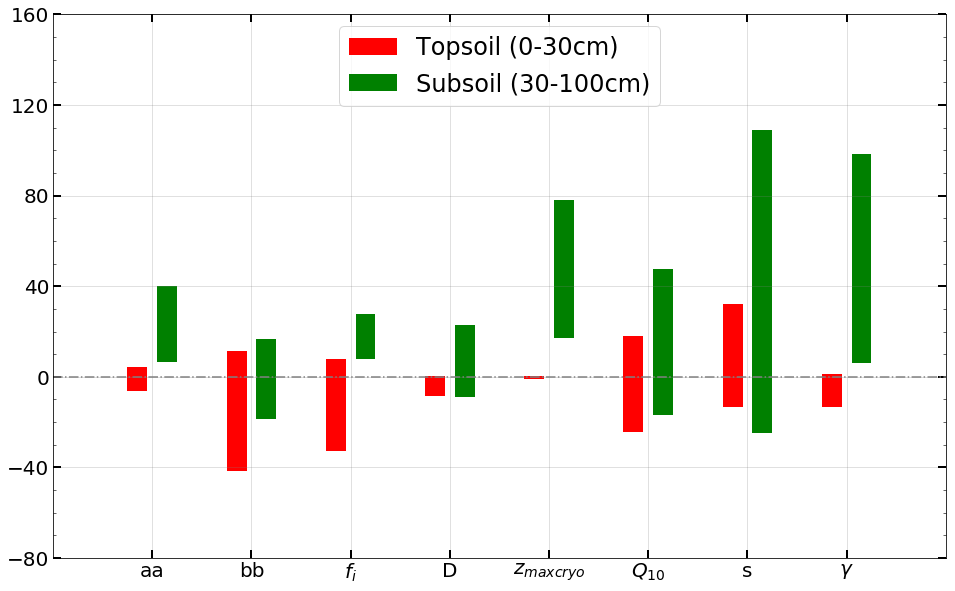

In [7]:
# SOC figure
lower_aa_top = min(mean_aa_soc_minus_top - mean_con_soc_top, mean_aa_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_aa_soc_minus_top - mean_con_soc_top, mean_aa_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
aa_top = abs(lower_aa_top) + abs(temp)

lower_aa_sub = min(mean_aa_soc_minus_sub - mean_con_soc_sub, mean_aa_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_aa_soc_plus_sub - mean_con_soc_sub, mean_aa_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
aa_sub = abs(lower_aa_sub) + abs(temp)

lower_bb_top = min(mean_bb_soc_minus_top - mean_con_soc_top, mean_bb_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_bb_soc_plus_top - mean_con_soc_top, mean_bb_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
bb_top = abs(lower_bb_top) + abs(temp)

lower_bb_sub = min(mean_bb_soc_minus_sub - mean_con_soc_sub, mean_bb_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_bb_soc_plus_sub - mean_con_soc_sub, mean_bb_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
bb_sub = abs(lower_bb_sub) + abs(temp)

lower_bd_top = min(mean_bd_soc_minus_top - mean_con_soc_top, mean_bd_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_bd_soc_plus_top - mean_con_soc_top, mean_bd_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
bd_top = abs(lower_bd_top) + abs(temp)

lower_bd_sub = min(mean_bd_soc_minus_sub - mean_con_soc_sub, mean_bd_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_bd_soc_plus_sub - mean_con_soc_sub, mean_bd_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
bd_sub = abs(lower_bd_sub) + abs(temp)

lower_d_top = min(mean_d_soc_minus_top - mean_con_soc_top, mean_d_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_d_soc_plus_top - mean_con_soc_top, mean_d_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
d_top = abs(lower_d_top) + abs(temp)

lower_d_sub = min(mean_d_soc_minus_sub - mean_con_soc_sub, mean_d_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_d_soc_plus_sub - mean_con_soc_sub, mean_d_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
d_sub = abs(lower_d_sub) + abs(temp)

lower_dep_top = min(mean_dep_soc_minus_top - mean_con_soc_top, mean_dep_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_dep_soc_plus_top - mean_con_soc_top, mean_dep_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
dep_top = abs(lower_dep_top) + abs(temp)

lower_dep_sub = min(mean_dep_soc_minus_sub - mean_con_soc_sub, mean_dep_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_dep_soc_plus_sub - mean_con_soc_sub, mean_dep_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
dep_sub = abs(lower_dep_sub) + abs(temp)

lower_q_top = min(mean_q_soc_minus_top - mean_con_soc_top, mean_q_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_q_soc_plus_top - mean_con_soc_top, mean_q_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
q_top = abs(lower_q_top) + abs(temp)

lower_q_sub = min(mean_q_soc_minus_sub - mean_con_soc_sub, mean_q_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_q_soc_plus_sub - mean_con_soc_sub, mean_q_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
q_sub = abs(lower_q_sub) + abs(temp)

lower_s_top = min(mean_s_soc_minus_top - mean_con_soc_top, mean_s_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_s_soc_plus_top - mean_con_soc_top, mean_s_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
s_top = abs(lower_s_top) + abs(temp)

lower_s_sub = min(mean_s_soc_minus_sub - mean_con_soc_sub, mean_s_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_s_soc_plus_sub - mean_con_soc_sub, mean_s_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
s_sub = abs(lower_s_sub) + abs(temp)

lower_gamma_top = min(mean_gamma_soc_minus_top - mean_con_soc_top, mean_gamma_soc_plus_top - mean_con_soc_top)/mean_con_soc_top*100
temp = max(mean_gamma_soc_plus_top - mean_con_soc_top, mean_gamma_soc_minus_top - mean_con_soc_top)/mean_con_soc_top*100
gamma_top = abs(lower_gamma_top) + abs(temp)

lower_gamma_sub = min(mean_gamma_soc_minus_sub - mean_con_soc_sub, mean_gamma_soc_plus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
temp = max(mean_gamma_soc_plus_sub - mean_con_soc_sub, mean_gamma_soc_minus_sub - mean_con_soc_sub)/mean_con_soc_sub*100
gamma_sub = abs(lower_gamma_sub) + abs(temp)

# Calculated from Testbed
#ncscd_30_m = 11.51
#ncscd_70_m = 13.43
#ncscd_30 = 5.84/ncscd_30_m*100
#ncscd_70 = 9.54/ncscd_70_m*100

blank_top = [lower_aa_top, lower_bb_top, lower_bd_top, lower_d_top, lower_dep_top, lower_q_top, lower_s_top,
             lower_gamma_top]
blank_sub = [lower_aa_sub, lower_bb_sub, lower_bd_sub, lower_d_sub, lower_dep_sub, lower_q_sub, lower_s_sub,
             lower_gamma_sub]
bval_top = [aa_top, bb_top, bd_top, d_top, dep_top, q_top, s_top, gamma_top]
bval_sub = [aa_sub, bb_sub, bd_sub, d_sub, dep_sub, q_sub, s_sub, gamma_sub]
xpos_top = [0.85, 1.85, 2.85, 3.85, 4.85, 5.85, 6.85, 7.85]
xpos_sub = [1.15, 2.15, 3.15, 4.15, 5.15, 6.15, 7.15, 8.15]

plt.figure(figsize=(16,10))
sentopplt = plt.bar(xpos_top, bval_top, width=0.2, bottom=blank_top, align='center', color='r')
sensubplt = plt.bar(xpos_sub, bval_sub, width=0.2, bottom=blank_sub, align='center', color='g')
ind = [1,2,3,4,5,6,7,8]
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.xticks(ind, ('aa', 'bb', '$f_i$', 'D', '$z_{maxcryo}$', '$Q_{10}$', 's', '$\gamma$'), fontsize=20)
plt.yticks([-80, -40, 0, 40, 80, 120, 160], fontsize=20)
plt.xlim((0, 9))
plt.ylim((-80, 160))
plt.legend(['Topsoil (0-30cm)', 'Subsoil (30-100cm)'], loc='upper center', fontsize=24)
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
#plt.plot(mpos_top, bline_top,'k')
#plt.plot(mpos_sub, bline_sub,'k')
plt.plot([0, 9], [0, 0], 'gray', linestyle='-.')

plt.show()
#plt.savefig('./figures/fig4/fig4a.png')

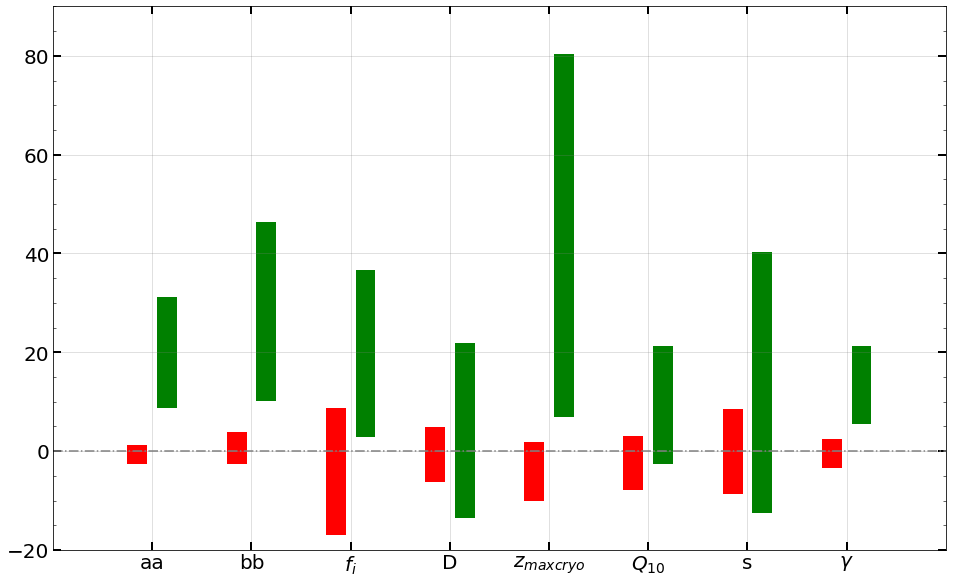

In [8]:
# Turnover figure
lower_aa_top = min(mean_aa_tau_minus_top - mean_con_tau_top, mean_aa_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_aa_tau_minus_top - mean_con_tau_top, mean_aa_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
aa_top = abs(lower_aa_top) + abs(temp)

lower_aa_sub = min(mean_aa_tau_minus_sub - mean_con_tau_sub, mean_aa_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_aa_tau_plus_sub - mean_con_tau_sub, mean_aa_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
aa_sub = abs(lower_aa_sub) + abs(temp)

lower_bb_top = min(mean_bb_tau_minus_top - mean_con_tau_top, mean_bb_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_bb_tau_plus_top - mean_con_tau_top, mean_bb_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
bb_top = abs(lower_bb_top) + abs(temp)

lower_bb_sub = min(mean_bb_tau_minus_sub - mean_con_tau_sub, mean_bb_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_bb_tau_plus_sub - mean_con_tau_sub, mean_bb_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
bb_sub = abs(lower_bb_sub) + abs(temp)

lower_bd_top = min(mean_bd_tau_minus_top - mean_con_tau_top, mean_bd_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_bd_tau_plus_top - mean_con_tau_top, mean_bd_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
bd_top = abs(lower_bd_top) + abs(temp)

lower_bd_sub = min(mean_bd_tau_minus_sub - mean_con_tau_sub, mean_bd_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_bd_tau_plus_sub - mean_con_tau_sub, mean_bd_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
bd_sub = abs(lower_bd_sub) + abs(temp)

lower_d_top = min(mean_d_tau_minus_top - mean_con_tau_top, mean_d_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_d_tau_plus_top - mean_con_tau_top, mean_d_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
d_top = abs(lower_d_top) + abs(temp)

lower_d_sub = min(mean_d_tau_minus_sub - mean_con_tau_sub, mean_d_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_d_tau_plus_sub - mean_con_tau_sub, mean_d_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
d_sub = abs(lower_d_sub) + abs(temp)

lower_dep_top = min(mean_dep_tau_minus_top - mean_con_tau_top, mean_dep_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_dep_tau_plus_top - mean_con_tau_top, mean_dep_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
dep_top = abs(lower_dep_top) + abs(temp)

lower_dep_sub = min(mean_dep_tau_minus_sub - mean_con_tau_sub, mean_dep_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_dep_tau_plus_sub - mean_con_tau_sub, mean_dep_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
dep_sub = abs(lower_dep_sub) + abs(temp)

lower_q_top = min(mean_q_tau_minus_top - mean_con_tau_top, mean_q_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_q_tau_plus_top - mean_con_tau_top, mean_q_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
q_top = abs(lower_q_top) + abs(temp)

lower_q_sub = min(mean_q_tau_minus_sub - mean_con_tau_sub, mean_q_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_q_tau_plus_sub - mean_con_tau_sub, mean_q_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
q_sub = abs(lower_q_sub) + abs(temp)

lower_s_top = min(mean_s_tau_minus_top - mean_con_tau_top, mean_s_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_s_tau_plus_top - mean_con_tau_top, mean_s_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
s_top = abs(lower_s_top) + abs(temp)

lower_s_sub = min(mean_s_tau_minus_sub - mean_con_tau_sub, mean_s_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_s_tau_plus_sub - mean_con_tau_sub, mean_s_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
s_sub = abs(lower_s_sub) + abs(temp)

lower_gamma_top = min(mean_gamma_tau_minus_top - mean_con_tau_top, mean_gamma_tau_plus_top - mean_con_tau_top)/mean_con_tau_top*100
temp = max(mean_gamma_tau_plus_top - mean_con_tau_top, mean_gamma_tau_minus_top - mean_con_tau_top)/mean_con_tau_top*100
gamma_top = abs(lower_gamma_top) + abs(temp)

lower_gamma_sub = min(mean_gamma_tau_minus_sub - mean_con_tau_sub, mean_gamma_tau_plus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
temp = max(mean_gamma_tau_plus_sub - mean_con_tau_sub, mean_gamma_tau_minus_sub - mean_con_tau_sub)/mean_con_tau_sub*100
gamma_sub = abs(lower_gamma_sub) + abs(temp)

blank_top = [lower_aa_top, lower_bb_top, lower_bd_top, lower_d_top, lower_dep_top, lower_q_top, lower_s_top,
             lower_gamma_top]
blank_sub = [lower_aa_sub, lower_bb_sub, lower_bd_sub, lower_d_sub, lower_dep_sub, lower_q_sub, lower_s_sub,
             lower_gamma_sub]
bval_top = [aa_top, bb_top, bd_top, d_top, dep_top, q_top, s_top, gamma_top]
bval_sub = [aa_sub, bb_sub, bd_sub, d_sub, dep_sub, q_sub, s_sub, gamma_sub]
xpos_top = [0.85, 1.85, 2.85, 3.85, 4.85, 5.85, 6.85, 7.85]
xpos_sub = [1.15, 2.15, 3.15, 4.15, 5.15, 6.15, 7.15, 8.15]

plt.figure(figsize=(16,10))
sentopplt = plt.bar(xpos_top, bval_top, width=0.2, bottom=blank_top, align='center', color='r')
sensubplt = plt.bar(xpos_sub, bval_sub, width=0.2, bottom=blank_sub, align='center', color='g')
ind = [1,2,3,4,5,6,7,8]
plt.grid(color='gray', which='major', axis='both', alpha=0.3)
plt.xticks(ind, ('aa', 'bb', '$f_i$', 'D', '$z_{maxcryo}$', '$Q_{10}$', 's', '$\gamma$'), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim((0, 9))
plt.ylim((-20, 90))
plt.minorticks_on()
plt.tick_params(axis='x',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='x',which='minor',bottom='off')
plt.tick_params(axis='y',which='major',direction='in',length=8, width=2)
plt.tick_params(axis='y',which='minor',direction='in',length=3)
plt.tick_params(axis="x", which="major", top=True)
plt.tick_params(axis="y", which="both", right=True)
plt.plot([0, 9], [0, 0], 'gray', linestyle='-.')

plt.show()
#plt.savefig('./figures/fig4/fig4b.png')

In [ ]:
mean_d_soc_plus_top = np.nanmean(outdf_sen['d_SOC_plus'][0:5].as_matrix())
std_d_soc_plus_top = np.nanstd(outdf_sen['d_SOC_plus'][0:5].as_matrix())
mean_d_soc_minus_top = np.nanmean(outdf_sen['d_SOC_minus'][0:5].as_matrix())
std_d_soc_minus_top = np.nanstd(outdf_sen['d_SOC_minus'][0:5].as_matrix())

mean_d_soc_plus_sub = np.nanmean(outdf_sen['d_SOC_plus'][5:10].as_matrix())
std_d_soc_plus_sub = np.nanstd(outdf_sen['d_SOC_plus'][5:10].as_matrix())
mean_d_soc_minus_sub = np.nanmean(outdf_sen['d_SOC_minus'][5:10].as_matrix())
std_d_soc_minus_sub = np.nanstd(outdf_sen['d_SOC_minus'][5:10].as_matrix())


In [ ]:
np.asarray(blank_sub)+np.asarray(bval_sub)

In [ ]:
blank_sub

In [ ]:
ncscd_30_m = 11.51
ncscd_70_m = 13.43
ncscd_30 = 5.84/ncscd_30_m*100
ncscd_70 = 9.54/ncscd_70_m*100
print(ncscd_30)
print(ncscd_70)

In [ ]:
np.nanstd(outdf_sen['d_SOC_minus'][0:5].as_matrix())

In [ ]:
mean_con_soc_top

In [ ]:
mean_con_soc_sub

In [ ]:
mean_dep_soc_minus_sub